In [2]:
import pandas as pd
import numpy as np

In [5]:
movies_df = pd.read_csv("movies.csv",usecols=['movieId','title'],dtype={'movieId':'int32'})
rating_df = pd.read_csv("ratings.csv",usecols=['userId','movieId','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})


In [6]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [9]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [12]:
df = pd.merge(rating_df,movies_df,on='movieId')
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [17]:
combine_movie_rating = df.dropna(axis=0,subset=['title'])
movie_ratingCount = (combine_movie_rating.
    groupby(by=['title'])['rating'].
    count().
    reset_index().
    rename(columns={'rating':'totalRatingCount'})
    [['title','totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [19]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount,left_on='title',right_on='title',how='left')
rating_with_totalRatingCount.head()


,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [57]:
pd.set_option('display.float_format',lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   9719.000
mean      10.375
std       22.406
min        1.000
25%        1.000
50%        3.000
75%        9.000
max      329.000
Name: totalRatingCount, dtype: float64


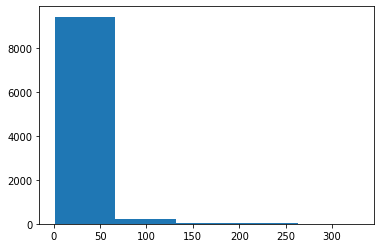

In [29]:
import matplotlib.pyplot as plt

x = [movie_ratingCount['totalRatingCount']]
plt.hist(x, bins = 5)
plt.show()

In [32]:
popularity_threshold = 50
rating_popularmovie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popularmovie.tail()

,userId,movieId,rating,title,totalRatingCount
79246,603,1997,4.000,"Exorcist, The (1973)",53
79247,606,1997,3.000,"Exorcist, The (1973)",53
79248,607,1997,5.000,"Exorcist, The (1973)",53
79249,608,1997,4.500,"Exorcist, The (1973)",53
79250,610,1997,4.000,"Exorcist, The (1973)",53


In [35]:
rating_popularmovie.shape

(41362, 5)

In [38]:
# let's create pivot table
movie_features_df = rating_popularmovie.pivot_table(index = 'title', columns='userId',values='rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,...,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,...,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000


In [44]:
from scipy.sparse import csr_matrix
movie_feature_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine',algorithm = 'brute')
model_knn.fit(movie_feature_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [46]:
movie_features_df.shape

(450, 606)

In [54]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distance,indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)

312


In [52]:
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,...,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,...,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000


In [55]:
for i in range(0,len(distance.flatten())):
    if i==0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}:{1},with distance of {2}:'.format(i,movie_features_df.index[indices.flatten()[i]],distance.flatten()[i]))
        

Recommendations for Pocahontas (1995):

1:Beauty and the Beast (1991),with distance of 0.4890720844268799:
2:Casper (1995),with distance of 0.5015525221824646:
3:Lion King, The (1994),with distance of 0.502167284488678:
4:Aladdin (1992),with distance of 0.5358314514160156:
5:Snow White and the Seven Dwarfs (1937),with distance of 0.5586729645729065:
